In [1]:
import psycopg2

# Database connection parameters: root_user
conn_string = "host='140.112.12.188' user='postgres' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)
print("Connection established")

# Create a cursor object
cursor = conn.cursor()
create_function_sql = """
CREATE FUNCTION site_policy(row_site int8, curr_user text)
RETURNS bool
AS $$
BEGIN
    RETURN (
        (SELECT Site_ID
        FROM Doctor WHERE UserName = curr_user) 
        = row_site
        );

END;
$$
LANGUAGE plpgsql;
"""
# Define the SQL for enabling row-level security and creating the policy
enable_rls_sql = """
ALTER TABLE patient
ENABLE ROW LEVEL SECURITY;

CREATE POLICY doctor_read
ON Patient
USING (site_policy(Site_ID, current_user));
"""

# Execute the SQL commands
try:
    # Drop policy if it exists
    cursor.execute("DROP POLICY IF EXISTS doctor_read ON Patient;")
    cursor.execute("DROP FUNCTION IF EXISTS site_policy(int8, text);")
    # Create the function
    cursor.execute(create_function_sql)
    print("Function created successfully")
    # Enable row-level security and create the policy
    cursor.execute(enable_rls_sql)
    conn.commit()
    print("Row-level security enabled and policy created successfully")

except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")


# Close the cursor and connection
cursor.close()
conn.close()

Connection established
Function created successfully
Row-level security enabled and policy created successfully


# Select

In [2]:
# Authorized
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE SELECT * FROM Patient WHERE ID_number='3769016772';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=34) (actual time=0.030..0.030 rows=0 loops=1)',)
("  Index Cond: ((id_number)::text = '3769016772'::text)",)
('  Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.155 ms',)
('Execution Time: 0.310 ms',)


In [3]:
# Unauthorized
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE SELECT * FROM Patient WHERE ID_number='3769016772';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=34) (actual time=0.064..0.065 rows=0 loops=1)',)
("  Index Cond: ((id_number)::text = '3769016772'::text)",)
('  Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.497 ms',)
('Execution Time: 0.846 ms',)


In [4]:
# Nonexist
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN SELECT * FROM Patient WHERE ID_number='12345678';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=34)',)
("  Index Cond: ((id_number)::text = '12345678'::text)",)
('  Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)


In [5]:
import time
# Doctor with site_ID 0
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)

# Create a cursor object
cursor = conn.cursor()
Authorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[(1000105, 'John Doe', '3463370605', 59, 0)]


In [6]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)

25342.825


In [7]:
# Another user with no permission
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Unauthorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
    end_time = time.perf_counter_ns()
    Unauthorized.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [8]:
avg_Unauthorized = sum(Unauthorized)/len(Unauthorized)
print(avg_Unauthorized)

23596.180000000004


In [9]:
# Another user with no permission and ID isn't in dataset
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

# Connect to the database
conn = psycopg2.connect(conn_string)
#print("Connection established")

# Create a cursor object
cursor = conn.cursor()
Non_Existent = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("SELECT * FROM Patient WHERE ID_number='37690167';")
    end_time = time.perf_counter_ns()
    Non_Existent.append((end_time-start_time)/10**3)
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [10]:
avg_Nonexist = sum(Non_Existent)/len(Non_Existent)
print(avg_Nonexist)

9018.875


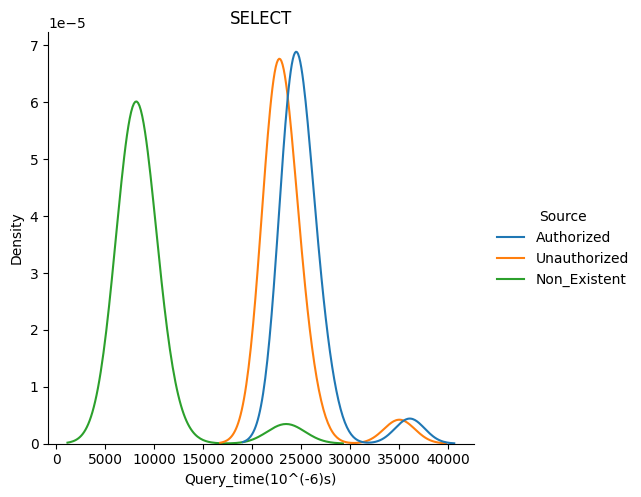

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#print(len(Unauthorized))
Authorized_arr = np.array(Authorized)
Authorized_df = pd.DataFrame(Authorized_arr, columns=['Query_time(10^(-6)s)'])
Unauthorized_arr = np.array(Unauthorized)
Unauthorized_df = pd.DataFrame(Unauthorized_arr, columns=['Query_time(10^(-6)s)'])
Non_Existent_arr = np.array(Non_Existent)
Non_Existent_df = pd.DataFrame(Non_Existent_arr, columns=['Query_time(10^(-6)s)'])

Authorized_df['Source'] = 'Authorized'
Unauthorized_df['Source'] = 'Unauthorized'
Non_Existent_df['Source'] = 'Non_Existent'

combined_df = pd.concat([Authorized_df, Unauthorized_df, Non_Existent_df], ignore_index=True)

sns.displot(data=combined_df, x='Query_time(10^(-6)s)', hue='Source', kind='kde').set(title="SELECT")
plt.show()

# Update

In [12]:
# Authorized
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=34.744..34.744 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=124) (actual time=19.153..19.155 rows=1 loops=1)',)
("        Index Cond: ((id_number)::text = '3463370605'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.455 ms',)
('Execution Time: 35.415 ms',)


In [13]:
# Unauthorized
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=15.397..15.397 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=124) (actual time=15.396..15.396 rows=0 loops=1)',)
("        Index Cond: ((id_number)::text = '3463370605'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('        Rows Removed by Filter: 1',)
('Planning Time: 0.167 ms',)
('Execution Time: 15.661 ms',)


In [14]:
# Not exist
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN (FORMAT JSON) UPDATE Patient SET name='Updated' WHERE ID_Number='12345';")
cursor.execute("EXPLAIN ANALYZE UPDATE Patient SET name='Updated' WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Update on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=17.595..17.596 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=124) (actual time=17.594..17.595 rows=0 loops=1)',)
("        Index Cond: ((id_number)::text = '3463370605'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('        Rows Removed by Filter: 1',)
('Planning Time: 0.082 ms',)
('Execution Time: 17.615 ms',)


In [15]:
# Authorized
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Authorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated'  WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
print(cursor.fetchall())
cursor.close()
conn.close()

[(1000105, 'Updated', '3463370605', 59, 0)]


In [16]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)

41464.17


In [17]:
# Unauthorized
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Unauthorized = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated'  WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Unauthorized.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='3463370605';")
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [18]:
avg_Unauthorized = sum(Unauthorized)/len(Unauthorized)
print(avg_Unauthorized)

24001.33


In [19]:
# Not exist
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
Non_Existent = []
for i in range(20):
    start_time = time.perf_counter_ns()
    cursor.execute("UPDATE Patient SET name='Updated' WHERE ID_Number='12345';")
    end_time = time.perf_counter_ns()
    Non_Existent.append((end_time-start_time)/10**3)
conn.commit()
cursor.execute("SELECT * FROM Patient WHERE ID_number='12345';")
print(cursor.fetchall())
cursor.close()
conn.close()

[]


In [20]:
avg_Nonexist = sum(Non_Existent)/len(Non_Existent)
print(avg_Nonexist)

8998.685000000001


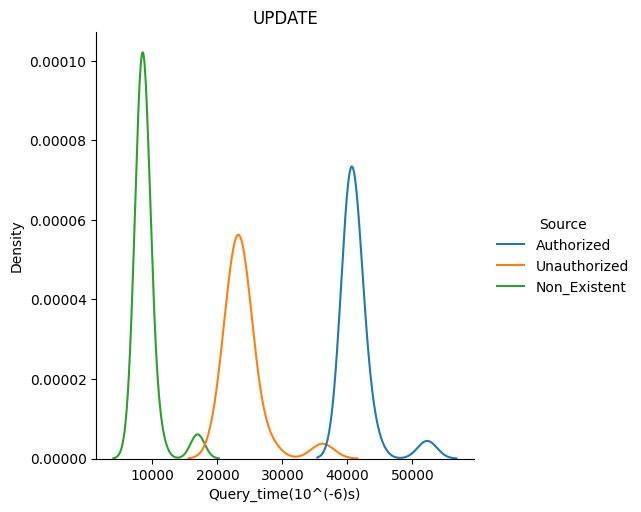

In [21]:
Authorized_arr = np.array(Authorized)
Authorized_df = pd.DataFrame(Authorized_arr, columns=['Query_time(10^(-6)s)'])
Unauthorized_arr = np.array(Unauthorized)
Unauthorized_df = pd.DataFrame(Unauthorized_arr, columns=['Query_time(10^(-6)s)'])
Non_Existent_arr = np.array(Non_Existent)
Non_Existent_df = pd.DataFrame(Non_Existent_arr, columns=['Query_time(10^(-6)s)'])

Authorized_df['Source'] = 'Authorized'
Unauthorized_df['Source'] = 'Unauthorized'
Non_Existent_df['Source'] = 'Non_Existent'

combined_df = pd.concat([Authorized_df, Unauthorized_df, Non_Existent_df], ignore_index=True)

sns.displot(data=combined_df, x='Query_time(10^(-6)s)', hue='Source', kind='kde').set(title="UPDATE")
plt.show()

# Delete

In [22]:
# Authorized
conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE DELETE FROM Patient WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Delete on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=19.147..19.148 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=6) (actual time=19.135..19.136 rows=1 loops=1)',)
("        Index Cond: ((id_number)::text = '3463370605'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.429 ms',)
('Execution Time: 19.832 ms',)


In [23]:
# Unauthorized
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE DELETE FROM Patient WHERE ID_Number='3463370605';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Delete on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=17.343..17.343 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=6) (actual time=17.342..17.342 rows=0 loops=1)',)
("        Index Cond: ((id_number)::text = '3463370605'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('        Rows Removed by Filter: 1',)
('Planning Time: 0.290 ms',)
('Execution Time: 17.797 ms',)


In [24]:
# Not exist
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE DELETE FROM Patient WHERE ID_Number='123456';")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()

('Delete on patient  (cost=0.42..8.70 rows=0 width=0) (actual time=0.048..0.048 rows=0 loops=1)',)
('  ->  Index Scan using patient_id_number_key on patient  (cost=0.42..8.70 rows=1 width=6) (actual time=0.046..0.047 rows=0 loops=1)',)
("        Index Cond: ((id_number)::text = '123456'::text)",)
('        Filter: site_policy((site_id)::bigint, (CURRENT_USER)::text)',)
('Planning Time: 0.330 ms',)
('Execution Time: 0.587 ms',)


In [25]:
# Authorized
Authorized = []
for i in range(20):
    conn_string = "host='140.112.12.188' user='lily543906' dbname='dbms_final' password='1234' port='5432'"
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()
    start_time = time.perf_counter_ns()
    cursor.execute("DELETE FROM Patient WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    conn.commit()
    Authorized.append((end_time-start_time)/10**3)
    cursor.execute("INSERT INTO Patient (name, ID_Number, Age, Site_ID) VALUES ('John Doe','3463370605','59','0');") 
    conn.commit()
    cursor.close()
    conn.close()


In [26]:
avg_Authorized = sum(Authorized)/len(Authorized)
print(avg_Authorized)

38102.475000000006


In [27]:
# Unauthorized
Unathorized = []
for i in range(20):
    conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()
    start_time = time.perf_counter_ns()
    cursor.execute("DELETE FROM Patient WHERE ID_Number='3463370605';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)  
    conn.commit()
    cursor.close()
    conn.close()  


In [28]:
avg_Unauthorized = sum(Unauthorized)/len(Unauthorized)
print(avg_Unauthorized)

24001.33


In [29]:
# Not exist
Unathorized = []
for i in range(20):
    conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()
    start_time = time.perf_counter_ns()
    cursor.execute("DELETE FROM Patient WHERE ID_Number='123456';")
    end_time = time.perf_counter_ns()
    Authorized.append((end_time-start_time)/10**3)  
    conn.commit()
    cursor.close()
    conn.close()  

In [30]:
avg_Nonexist = sum(Non_Existent)/len(Non_Existent)
print(avg_Nonexist)

8998.685000000001


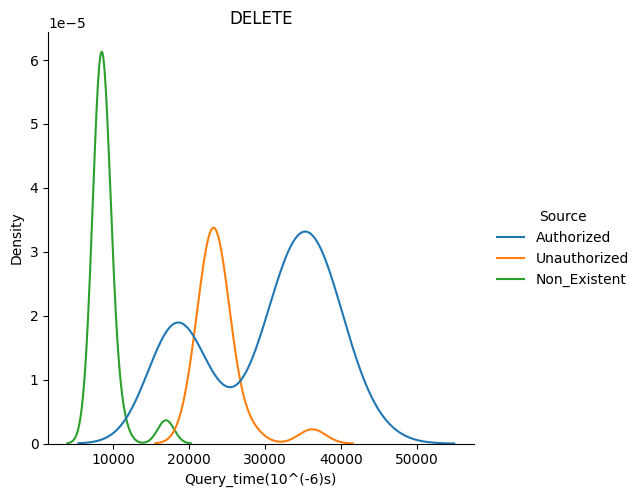

In [31]:
Authorized_arr = np.array(Authorized)
Authorized_df = pd.DataFrame(Authorized_arr, columns=['Query_time(10^(-6)s)'])
Unauthorized_arr = np.array(Unauthorized)
Unauthorized_df = pd.DataFrame(Unauthorized_arr, columns=['Query_time(10^(-6)s)'])
Non_Existent_arr = np.array(Non_Existent)
Non_Existent_df = pd.DataFrame(Non_Existent_arr, columns=['Query_time(10^(-6)s)'])

Authorized_df['Source'] = 'Authorized'
Unauthorized_df['Source'] = 'Unauthorized'
Non_Existent_df['Source'] = 'Non_Existent'

combined_df = pd.concat([Authorized_df, Unauthorized_df, Non_Existent_df], ignore_index=True)

sns.displot(data=combined_df, x='Query_time(10^(-6)s)', hue='Source', kind='kde').set(title="DELETE")
plt.show()

# INSERT

In [32]:
# Authorized
"""
conn_string = "host='140.112.12.188' user='andychang' dbname='dbms_final' password='1234' port='5432'"
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("EXPLAIN ANALYZE INSERT INTO Patient (name, ID_Number, Age, Site_ID) VALUES ('John Doe','3463370601','59','0');")
query_plan = cursor.fetchall()
for row in query_plan:
    print(row)
cursor.close()
conn.close()
"""

InsufficientPrivilege: new row violates row-level security policy for table "patient"
